## Multiclass-Classification

### Here we are to introduce another label named `neutral` in addition to the `negative` and `positive` 

In [3]:
# --- 1. Import Libraries ---
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline


import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [4]:
# --- 2. Load Data ---
text_cleaned = pd.read_csv("../../assets/Cleaned_Tweets.csv")
text_cleaned.head()

,tweet,emotion,product_filled,cleaned_tweets,text_length
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,negative,iphone,3g iphone 3 hrs tweeting rise_austin dead need...,12
1,@jessedee know about @fludapp ? awesome ipad/i...,positive,ipad or iphone app,know awesome ipadiphone app youll likely appre...,14
2,@swonderlin can not wait for #ipad 2 also. the...,positive,ipad,wait ipad 2 also sale sxsw,6
3,@sxsw i hope this year's festival isn't as cra...,negative,ipad or iphone app,hope years festival isnt crashy years iphone a...,9
4,@sxtxstate great stuff on fri #sxsw: marissa m...,positive,google,great stuff fri sxsw marissa mayer google tim ...,15


In [6]:
multi_df = text_cleaned[text_cleaned["emotion"].isin(['positive', 'negative','neutral'])]
multi_df

,tweet,emotion,product_filled,cleaned_tweets,text_length
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,negative,iphone,3g iphone 3 hrs tweeting rise_austin dead need...,12
1,@jessedee know about @fludapp ? awesome ipad/i...,positive,ipad or iphone app,know awesome ipadiphone app youll likely appre...,14
2,@swonderlin can not wait for #ipad 2 also. the...,positive,ipad,wait ipad 2 also sale sxsw,6
3,@sxsw i hope this year's festival isn't as cra...,negative,ipad or iphone app,hope years festival isnt crashy years iphone a...,9
4,@sxtxstate great stuff on fri #sxsw: marissa m...,positive,google,great stuff fri sxsw marissa mayer google tim ...,15
...,...,...,...,...,...
9087,ipad everywhere. #sxsw {link},positive,ipad,ipad everywhere sxsw link,4
9088,"wave, buzz... rt @mention we interrupt your re...",neutral,google,wave buzz rt interrupt regularly scheduled sxs...,14
9089,"google's zeiger, a physician never reported po...",neutral,google,googles zeiger physician never reported potent...,17
9090,some verizon iphone customers complained their...,neutral,iphone,verizon iphone customers complained time fell ...,14


In [7]:
X_multi = multi_df["cleaned_tweets"]
y_multi = multi_df["emotion"]

y_multi = y_multi.map({'negative': 0, 'positive': 1, 'neutral': 2})


Xmultib_train, Xmultib_test, ymultib_train, ymultib_test = train_test_split(
    X_multi, y_multi, test_size=0.2, random_state=42, stratify=y_multi
)

### - Splitting data into test, train and validation data to be able to both train, test and validate our models

In [8]:
Xmultib_temp, Xmultib_val, ymultib_temp, ymultib_val= train_test_split(
    Xmultib_train, ymultib_train, test_size=0.2, random_state=42, stratify=ymultib_train
)

### Baseline Model (Logistic Regression ) with TDIDF

In [9]:
sentiment_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ("clf", LogisticRegression(max_iter=1000))
])

# Fit pipeline
sentiment_pipeline.fit(Xmultib_temp, ymultib_temp)

# Predictions
y_pred = sentiment_pipeline.predict(Xmultib_val)

# Evaluation
print("Classification Report:\n", classification_report(ymultib_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(ymultib_val, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.09      0.16        91
           1       0.63      0.47      0.54       477
           2       0.70      0.87      0.78       862

    accuracy                           0.69      1430
   macro avg       0.74      0.48      0.49      1430
weighted avg       0.69      0.69      0.66      1430

Confusion Matrix:
 [[  8  18  65]
 [  1 225 251]
 [  0 113 749]]


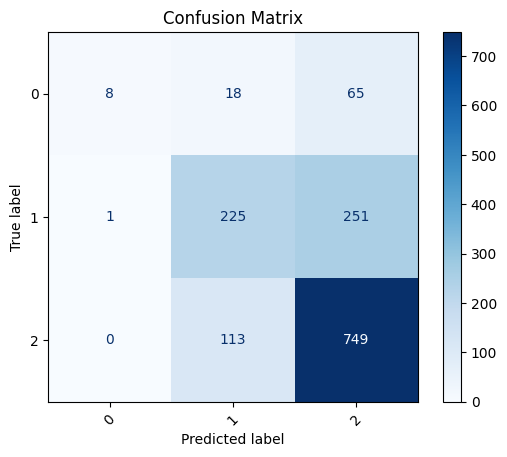

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = sentiment_pipeline.predict(Xmultib_val)
cm = confusion_matrix(ymultib_val, y_pred)
labels = sentiment_pipeline.classes_
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", values_format="d", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


- The model performs **best on class 2** (good recall and precision).  
- It struggles **heavily with class 0**, where most samples are wrongly classified as class 2.  
- Class 1 has **moderate performance**, but a large portion is still misclassified as class 2.  
- The imbalance in class distribution (class 2 has the most samples) likely contributes to the poor recall of minority classes (especially class 0).

###  Managing class imbalance with SMOTE

In [11]:
smote_pipeline = ImbPipeline([
    ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ("smote", SMOTE(random_state=42)),
    ("clf", LogisticRegression(max_iter=1000, class_weight=None))  # class_weight not needed since we use SMOTE
])

# Fit pipeline
smote_pipeline.fit(Xmultib_temp, ymultib_temp)

# Predictions
y_pred = smote_pipeline.predict(Xmultib_val)

# Evaluation
print("Classification Report:\n", classification_report(ymultib_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(ymultib_val, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.42      0.35        91
           1       0.56      0.59      0.57       477
           2       0.75      0.70      0.72       862

    accuracy                           0.64      1430
   macro avg       0.54      0.57      0.55      1430
weighted avg       0.66      0.64      0.65      1430

Confusion Matrix:
 [[ 38  22  31]
 [ 29 282 166]
 [ 57 204 601]]


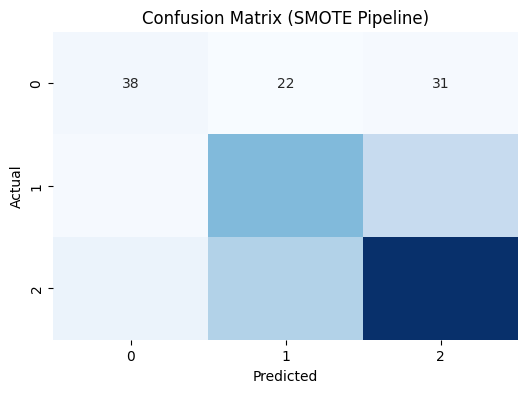

In [12]:

y_pred = smote_pipeline.predict(Xmultib_val)
cm = confusion_matrix(ymultib_val, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=smote_pipeline.classes_,
            yticklabels=smote_pipeline.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (SMOTE Pipeline)")
plt.show()



1. **SMOTE greatly improved recall for Class 0**, which was nearly ignored before.  
2. The model is now **more balanced across all three classes** (macro recall improved from 0.48 → 0.57).  
3. Accuracy dropped slightly (69% → 64%), but this is expected because the model now prioritizes **fairness across classes** instead of always favoring the majority class.  
4. Trade-off: More false positives for Class 0, but much better representation overall.  


## GRID SEARCH      

In [15]:
from sklearn.model_selection import GridSearchCV     
param_grid = {
    "tfidf__max_features": [3000, 5000, 7000],
    "tfidf__ngram_range": [(1,1), (1,2)],
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__solver": ["liblinear", "lbfgs"],
    "clf__penalty": ["l2"] 
}

# Grid search
grid_search = GridSearchCV(
    smote_pipeline,
    param_grid,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=2
)

# Fit grid search
grid_search.fit(Xmultib_train, ymultib_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(Xmultib_test)

from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:\n", classification_report(ymultib_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(ymultib_test, y_pred))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'liblinear', 'tfidf__max_features': 7000, 'tfidf__ngram_range': (1, 1)}

Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.53      0.46       114
           1       0.58      0.64      0.61       596
           2       0.77      0.70      0.73      1078

    accuracy                           0.67      1788
   macro avg       0.59      0.62      0.60      1788
weighted avg       0.68      0.67      0.67      1788


Confusion Matrix:
 [[ 60  20  34]
 [ 22 381 193]
 [ 63 259 756]]


Interpretation by Class

1. Class 0 (minority, 114 samples):

- Recall improved to 0.53, meaning the model is now catching more than half of these cases.
- Precision is lower (0.41), showing some false positives, but this is a fair trade-off for better recall.

2. Class 1 (596 samples):

- Balanced performance (Precision = 0.58, Recall = 0.64, F1 = 0.61).
- Model is doing better than before in both capturing class 1 and keeping false positives under control.

3. Class 2 (majority, 1078 samples):

- Strongest performance overall: Precision = 0.77, Recall = 0.70.
- Slight trade-off between recall and precision, but still the best-performing class.

### Pipeline with Different Models (SVM, RANDOM FOREST, XGBOOST, GRADIENT BOOSTING)

In [16]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score



models = {
    "SVM": LinearSVC(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

results = {}

for name, clf in models.items():
    pipe = ImbPipeline([
        ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
        ("smote", SMOTE(random_state=42)),
        ("clf", clf)
    ])
    
     # Fit
    pipe.fit(Xmultib_temp, ymultib_temp)
    
    # Predict
    y_pred = pipe.predict(Xmultib_val)
    
    # Evaluate
    acc = accuracy_score(ymultib_val, y_pred)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(ymultib_val, y_pred))
    
    results[name] = acc

print("\nSummary of Results:", results)



SVM Accuracy: 0.6399
              precision    recall  f1-score   support

           0       0.33      0.35      0.34        91
           1       0.55      0.60      0.57       477
           2       0.74      0.69      0.72       862

    accuracy                           0.64      1430
   macro avg       0.54      0.55      0.54      1430
weighted avg       0.65      0.64      0.64      1430


Random Forest Accuracy: 0.6874
              precision    recall  f1-score   support

           0       0.51      0.22      0.31        91
           1       0.64      0.50      0.56       477
           2       0.71      0.84      0.77       862

    accuracy                           0.69      1430
   macro avg       0.62      0.52      0.55      1430
weighted avg       0.67      0.69      0.67      1430



C:\Users\User\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [01:34:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Accuracy: 0.6601
              precision    recall  f1-score   support

           0       0.33      0.21      0.26        91
           1       0.61      0.45      0.52       477
           2       0.70      0.82      0.76       862

    accuracy                           0.66      1430
   macro avg       0.54      0.49      0.51      1430
weighted avg       0.64      0.66      0.64      1430


Gradient Boosting Accuracy: 0.6168
              precision    recall  f1-score   support

           0       0.21      0.35      0.26        91
           1       0.58      0.44      0.50       477
           2       0.70      0.74      0.72       862

    accuracy                           0.62      1430
   macro avg       0.50      0.51      0.49      1430
weighted avg       0.63      0.62      0.62      1430


Summary of Results: {'SVM': 0.6398601398601399, 'Random Forest': 0.6874125874125874, 'XGBoost': 0.6601398601398601, 'Gradient Boosting': 0.6167832167832168}


### Fine Tuning the Models

In [17]:
# Define models and param grids
from sklearn.metrics import f1_score


models_and_params = {
    "SVM": (
        LinearSVC(random_state=42),
        {
            "clf__C": [0.1, 1, 10]
        }
    ),
    "Random Forest": (
        RandomForestClassifier(random_state=42),
        {
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [None, 10, 20]
        }
    ),
    "XGBoost": (
        XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
        {
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [3, 6, 10],
            "clf__learning_rate": [0.1, 0.3]
        }
    ),
    "Gradient Boosting": (
        GradientBoostingClassifier(random_state=42),
        {
            "clf__n_estimators": [100, 200],
            "clf__learning_rate": [0.05, 0.1, 0.3],
            "clf__max_depth": [3, 5]
        }
    )
}

results = {}

for name, (clf, param_grid) in models_and_params.items():
    print(f"\n Running GridSearch for {name}...")
    
    pipe = ImbPipeline([
        ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
        ("smote", SMOTE(random_state=42)),
        ("clf", clf)
    ])
    
    grid = GridSearchCV(pipe, param_grid, cv=3, scoring="accuracy", n_jobs=-1, verbose=1)
    grid.fit(Xmultib_temp, ymultib_temp)
    
    y_pred = grid.predict(Xmultib_val)
    
    acc = accuracy_score(ymultib_val, y_pred)
    f1 = f1_score(ymultib_val, y_pred, average="macro")

    print(f"{name} Best Params: {grid.best_params_}")
    print(f"{name} Accuracy: {acc:.4f},  Macro F1: {f1:.4f}")
    print(classification_report(ymultib_val, y_pred))
    
    results[name] = {"Accuracy": acc, "Best Params": grid.best_params_}

print("\n Summary of Results:")
for model, res in results.items():
    print(f"{model}: Accuracy={res['Accuracy']:.4f}, Best Params={res['Best Params']}")


 Running GridSearch for SVM...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
SVM Best Params: {'clf__C': 1}
SVM Accuracy: 0.6399,  Macro F1: 0.5422
              precision    recall  f1-score   support

           0       0.33      0.35      0.34        91
           1       0.55      0.60      0.57       477
           2       0.74      0.69      0.72       862

    accuracy                           0.64      1430
   macro avg       0.54      0.55      0.54      1430
weighted avg       0.65      0.64      0.64      1430


 Running GridSearch for Random Forest...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Random Forest Best Params: {'clf__max_depth': None, 'clf__n_estimators': 200}
Random Forest Accuracy: 0.6874,  Macro F1: 0.5463
              precision    recall  f1-score   support

           0       0.51      0.22      0.31        91
           1       0.64      0.50      0.56       477
           2       0.71      0.84      0.77       862

    accur

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [01:41:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Best Params: {'clf__learning_rate': 0.1, 'clf__max_depth': 10, 'clf__n_estimators': 200}
XGBoost Accuracy: 0.6699,  Macro F1: 0.5123
              precision    recall  f1-score   support

           0       0.34      0.19      0.24        91
           1       0.62      0.47      0.53       477
           2       0.70      0.83      0.76       862

    accuracy                           0.67      1430
   macro avg       0.55      0.50      0.51      1430
weighted avg       0.65      0.67      0.65      1430


 Running GridSearch for Gradient Boosting...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Gradient Boosting Best Params: {'clf__learning_rate': 0.3, 'clf__max_depth': 5, 'clf__n_estimators': 200}
Gradient Boosting Accuracy: 0.6664,  Macro F1: 0.5424
              precision    recall  f1-score   support

           0       0.40      0.26      0.32        91
           1       0.58      0.54      0.56       477
           2       0.72      0.78      0.75     

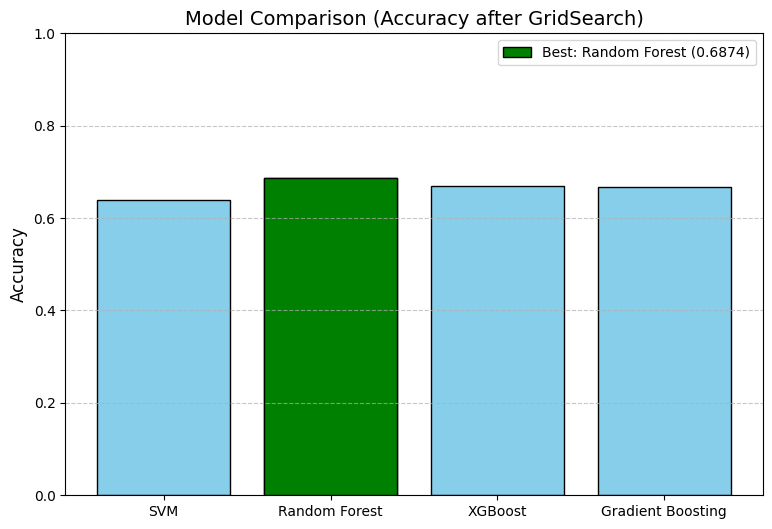


 Best Model: Random Forest
   Accuracy: 0.6874
   Best Params: {'clf__max_depth': None, 'clf__n_estimators': 200}


In [18]:
plt.figure(figsize=(9,6))
accuracies = {m: res["Accuracy"] for m, res in results.items()}
plt.bar(accuracies.keys(), accuracies.values(), color="skyblue", edgecolor="black")

# Highlight best model
best_model = max(accuracies, key=accuracies.get)
best_acc = accuracies[best_model]
plt.bar(best_model, best_acc, color="green", edgecolor="black",
        label=f"Best: {best_model} ({best_acc:.4f})")

plt.title("Model Comparison (Accuracy after GridSearch)", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0,1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.show()

print(f"\n Best Model: {best_model}")
print(f"   Accuracy: {best_acc:.4f}")
print(f"   Best Params: {results[best_model]['Best Params']}")






### Here the best model is Random Forest
we will use this pipeline to train and get the best models measuring accuracy and f1 score and then save the model using joblib

In [19]:
from sklearn.metrics import f1_score, accuracy_score, classification_report
import joblib

models_and_params = {
    "SVM": (
        LinearSVC(random_state=42),
        {
            "clf__C": [0.1, 1, 10]
        }
    ),
    "Random Forest": (
        RandomForestClassifier(random_state=42),
        {
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [None, 10, 20]
        }
    ),
    "XGBoost": (
        XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
        {
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [3, 6, 10],
            "clf__learning_rate": [0.1, 0.3]
        }
    ),
    "Gradient Boosting": (
        GradientBoostingClassifier(random_state=42),
        {
            "clf__n_estimators": [100, 200],
            "clf__learning_rate": [0.05, 0.1, 0.3],
            "clf__max_depth": [3, 5]
        }
    )
}

results = {}
best_model = None
best_model_name = None
best_f1 = -1  # keep track of best macro f1 score

for name, (clf, param_grid) in models_and_params.items():
    print(f"\n Running GridSearch for {name}...")
    
    pipe = ImbPipeline([
        ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
        ("smote", SMOTE(random_state=42)),
        ("clf", clf)
    ])
    
    grid = GridSearchCV(pipe, param_grid, cv=3, scoring="f1_macro", n_jobs=-1, verbose=1)
    grid.fit(Xmultib_temp, ymultib_temp)
    
    y_pred = grid.predict(Xmultib_val)
    
    acc = accuracy_score(ymultib_val, y_pred)
    f1 = f1_score(ymultib_val, y_pred, average="macro")

    print(f"{name} Best Params: {grid.best_params_}")
    print(f"{name} Accuracy: {acc:.4f},  Macro F1: {f1:.4f}")
    print(classification_report(ymultib_val, y_pred))
    
    results[name] = {
        "Accuracy": acc,
        "Macro F1": f1,
        "Best Params": grid.best_params_,
        "Best Estimator": grid.best_estimator_
    }

    # track the best model by macro f1
    if f1 > best_f1:
        best_f1 = f1
        best_model = grid.best_estimator_
        best_model_name = name

print("\n Summary of Results:")
for model, res in results.items():
    print(f"{model}: Accuracy={res['Accuracy']:.4f}, Macro F1={res['Macro F1']:.4f}, Best Params={res['Best Params']}")

# Save the best model
joblib.dump(best_model, f"best_model_{best_model_name.replace(' ', '_').lower()}.pkl")
print(f"\nBest model saved as best_model_{best_model_name.replace(' ', '_').lower()}.pkl (Model: {best_model_name}, Macro F1={best_f1:.4f})")



 Running GridSearch for SVM...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
SVM Best Params: {'clf__C': 1}
SVM Accuracy: 0.6399,  Macro F1: 0.5422
              precision    recall  f1-score   support

           0       0.33      0.35      0.34        91
           1       0.55      0.60      0.57       477
           2       0.74      0.69      0.72       862

    accuracy                           0.64      1430
   macro avg       0.54      0.55      0.54      1430
weighted avg       0.65      0.64      0.64      1430


 Running GridSearch for Random Forest...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Random Forest Best Params: {'clf__max_depth': None, 'clf__n_estimators': 100}
Random Forest Accuracy: 0.6867,  Macro F1: 0.5424
              precision    recall  f1-score   support

           0       0.51      0.21      0.30        91
           1       0.62      0.50      0.56       477
           2       0.72      0.84      0.77       862

    accur

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [01:56:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Best Params: {'clf__learning_rate': 0.3, 'clf__max_depth': 10, 'clf__n_estimators': 100}
XGBoost Accuracy: 0.6720,  Macro F1: 0.5190
              precision    recall  f1-score   support

           0       0.38      0.19      0.25        91
           1       0.60      0.50      0.54       477
           2       0.71      0.82      0.76       862

    accuracy                           0.67      1430
   macro avg       0.56      0.50      0.52      1430
weighted avg       0.65      0.67      0.66      1430


 Running GridSearch for Gradient Boosting...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Gradient Boosting Best Params: {'clf__learning_rate': 0.3, 'clf__max_depth': 5, 'clf__n_estimators': 100}
Gradient Boosting Accuracy: 0.6671,  Macro F1: 0.5348
              precision    recall  f1-score   support

           0       0.32      0.26      0.29        91
           1       0.60      0.52      0.56       477
           2       0.72      0.79      0.75     

### BERT

In [ ]:
from datasets import Dataset
from sklearn.model_selection import train_test_split

# Use same labels as your notebook
label2id = {"negative": 0, "positive": 1, "neutral": 2}
id2label = {v: k for k, v in label2id.items()}

df = pd.DataFrame({"text": X_multi, "label": y_multi})

# Train/val/test split
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df["text"], df["label"], test_size=0.3, stratify=df["label"], random_state=42
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

train_df = pd.DataFrame({"text": train_texts, "label": train_labels})
val_df   = pd.DataFrame({"text": val_texts, "label": val_labels})
test_df  = pd.DataFrame({"text": test_texts, "label": test_labels})

train_dataset = Dataset.from_pandas(train_df)
val_dataset   = Dataset.from_pandas(val_df)
test_dataset  = Dataset.from_pandas(test_df)


##  Tokenize Text with BERT Tokenizer

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, classification_report
import joblib

models_and_params = {
    "SVM": (
        LinearSVC(random_state=42),
        {
            "clf__C": [0.1, 1, 10]
        }
    ),
    "Random Forest": (
        RandomForestClassifier(random_state=42),
        {
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [None, 10, 20]
        }
    ),
    "XGBoost": (
        XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
        {
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [3, 6, 10],
            "clf__learning_rate": [0.1, 0.3]
        }
    ),
    "Gradient Boosting": (
        GradientBoostingClassifier(random_state=42),
        {
            "clf__n_estimators": [100, 200],
            "clf__learning_rate": [0.05, 0.1, 0.3],
            "clf__max_depth": [3, 5]
        }
    )
}

results = {}
best_model = None
best_model_name = None
best_f1 = -1  # keep track of best macro f1 score

for name, (clf, param_grid) in models_and_params.items():
    print(f"\n Running GridSearch for {name}...")
    
    pipe = ImbPipeline([
        ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
        ("smote", SMOTE(random_state=42)),
        ("clf", clf)
    ])
    
    grid = GridSearchCV(pipe, param_grid, cv=3, scoring="f1_macro", n_jobs=-1, verbose=1)
    grid.fit(Xmultib_temp, ymultib_temp)
    
    y_pred = grid.predict(Xmultib_val)
    
    acc = accuracy_score(ymultib_val, y_pred)
    f1 = f1_score(ymultib_val, y_pred, average="macro")

    print(f"{name} Best Params: {grid.best_params_}")
    print(f"{name} Accuracy: {acc:.4f},  Macro F1: {f1:.4f}")
    print(classification_report(ymultib_val, y_pred))
    
    results[name] = {
        "Accuracy": acc,
        "Macro F1": f1,
        "Best Params": grid.best_params_,
        "Best Estimator": grid.best_estimator_
    }

    # track the best model by macro f1
    if f1 > best_f1:
        best_f1 = f1
        best_model = grid.best_estimator_
        best_model_name = name

print("\n Summary of Results:")
for model, res in results.items():
    print(f"{model}: Accuracy={res['Accuracy']:.4f}, Macro F1={res['Macro F1']:.4f}, Best Params={res['Best Params']}")

# Save the best model
joblib.dump(best_model, f"best_model_{best_model_name.replace(' ', '_').lower()}.pkl")
print(f"\nBest model saved as best_model_{best_model_name.replace(' ', '_').lower()}.pkl (Model: {best_model_name}, Macro F1={best_f1:.4f})")


In [29]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset   = val_dataset.map(tokenize, batched=True)
test_dataset  = test_dataset.map(tokenize, batched=True)

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])


Map:   0%|          | 0/6255 [00:00<?, ? examples/s]

Map:   0%|          | 0/1340 [00:00<?, ? examples/s]

Map:   0%|          | 0/1341 [00:00<?, ? examples/s]

### Define BERT Model

In [30]:
from transformers import BertForSequenceClassification

num_labels = len(label2id)
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Training Setup

In [31]:

from transformers import TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}



In [19]:
training_args = TrainingArguments(
    output_dir="./results",
    do_eval=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
)

### Train BERT


In [20]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    
)

trainer.train()


C:\Users\User\AppData\Local\Temp\ipykernel_22740\984575968.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.696238,0.678358,0.425088,0.794384,0.431369
2,0.746000,0.655312,0.711194,0.601812,0.648322,0.577742
3,0.515400,0.713067,0.712687,0.622946,0.628478,0.618224


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=1173, training_loss=0.5976742860707888, metrics={'train_runtime': 50473.5947, 'train_samples_per_second': 0.372, 'train_steps_per_second': 0.023, 'total_flos': 1234330820916480.0, 'train_loss': 0.5976742860707888, 'epoch': 3.0})

# Training Output 

### **Global Step**
- **Value:** `1173`  
- Represents the total number of update steps completed during training.  
- Each step usually corresponds to one batch of training data.

---

### **Training Loss**
- **Value:** `0.5976742860707888`  
- The final average training loss after all epochs.  
- Lower values generally indicate better fitting of the model to the training data.

---

### **Metrics**

1. **Train Runtime**
   - **Value:** `50473.5947` seconds (~14 hours)  
   - The total time taken for the entire training process.

2. **Train Samples per Second**
   - **Value:** `0.372` samples/sec  
   - The throughput: how many training samples the model processed each second.  
   - Low values usually indicate that the training setup is computationally heavy.

3. **Train Steps per Second**
   - **Value:** `0.023` steps/sec  
   - The number of optimizer update steps per second.  
   - Reflects how fast batches are processed.

4. **Total FLOPs**
   - **Value:** `1.23433082091648e+15`  
   - Estimated number of floating-point operations performed during training.  
   - This shows the computational cost.

5. **Train Loss**
   - **Value:** `0.5976742860707888`  
   - Duplicate of the training loss (for convenience in the metrics dictionary).  

6. **Epoch**
   - **Value:** `3.0`  
   - Total number of times the entire dataset was passed through the model.

---

### **Summary**
- The model was trained for **3 epochs**.  
- It completed **1173 steps** in ~14 hours.  
- The average loss is **~0.598**, showing moderate performance.  
- Training speed is **very low (0.372 samples/sec)**, suggesting opportunities to optimize the training process (e.g., smaller model, mixed precision training, smaller batch size, or GPU acceleration).

---


### 

In [23]:
results = trainer.evaluate(test_dataset)
print(results)


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.6717896461486816, 'eval_accuracy': 0.7307979120059657, 'eval_f1': 0.6152632572431611, 'eval_precision': 0.6755409572886318, 'eval_recall': 0.5892976072524452, 'eval_runtime': 727.4195, 'eval_samples_per_second': 1.844, 'eval_steps_per_second': 0.115, 'epoch': 3.0}


##  Model Evaluation Summary (Epoch 3)

- **Loss**: `0.67` → Model still makes some errors, but acceptable for text classification.
- **Accuracy**: **73.1%** → About 73% of predictions were correct.
- **F1 Score**: **0.62** → Balanced precision/recall performance; moderate overall.
- **Precision**: **0.68** → When the model predicts a label, it is correct ~68% of the time.
- **Recall**: **0.59** → Captures ~59% of the true labels (misses some).
- **Runtime**: **727s (~12 minutes)**  
  - ~**1.84 samples/sec**  
  - ~**0.12 steps/sec**

---

###  Interpretation
- Model is **more precise than sensitive** (higher precision than recall).  
- Accuracy (73%) is solid, but recall (59%) shows it misses some cases.  
- F1 score (0.62) reflects **moderate performance** — decent baseline but improvable.  

---

  


 ----

###  1. Load the saved model

In [ ]:
import joblib

# Load the saved model
best_model = joblib.load("best_model.pkl")


###  2. Run on test data

In [ ]:
# Predict on test set
y_pred = best_model.predict(X_test)

# Evaluate performance
from sklearn.metrics import classification_report, f1_score, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro F1:", f1_score(y_test, y_pred, average="macro"))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


### 3. Predict on new unseen data

In [ ]:
new_texts = [
    "I really love this product!", 
    "This is terrible, I hate it."
]

predictions = best_model.predict(new_texts)

print(predictions)
